In [9]:
# Import statements
import json
import numpy as np
import matplotlib as mtplb
import matplotlib.pyplot as plt
import skimage.io as skio
import scipy
import skimage as sk
import cv2

<h1>Part 1</h1>

In [10]:
# Open the images
hailey = skio.imread("../images/hailey.jpg") / 255
george = skio.imread("../images/george.jpg") / 255

# Opening JSON file
f = open('hailey_george.json',)
   
# returns JSON object as 
# a dictionary
data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

assert(len(im1_points) == len(im2_points))
   
# Closing file
f.close()

In [11]:
# Compute the mean of the two point sets
mean_points = (im1_points + im2_points)/2
# print(mean_points.shape)
# print(mean_points)

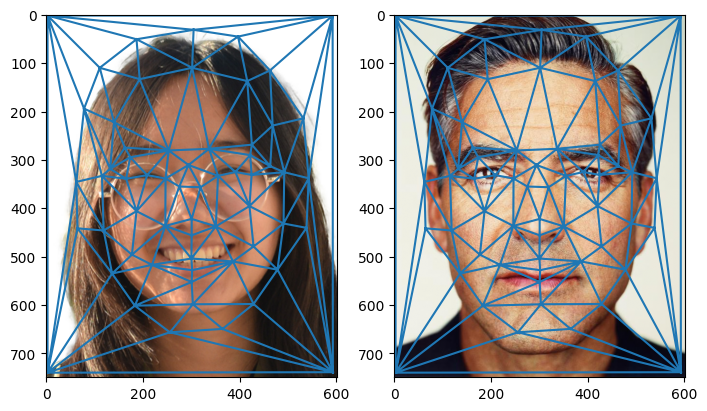

In [12]:
# Create triangulation on the images
triangulation = scipy.spatial.Delaunay(mean_points)
triangles = triangulation.simplices

plt.figure(figsize=(8, 4), layout="compressed")
plt.subplot(121); plt.triplot(mean_points[:,0], mean_points[:,1], triangulation.simplices); plt.gca().invert_yaxis(); plt.imshow(hailey)
plt.subplot(122); plt.triplot(mean_points[:,0], mean_points[:,1], triangulation.simplices); plt.gca().invert_yaxis(); plt.imshow(george)

In [13]:
# print(triangles.shape)
# print(triangles)

<h1>Part 2</h1>

In [14]:
def computeAffine(tri1_pts, tri2_pts):
    a = np.vstack([tri1_pts[0], tri1_pts[1], np.ones(3)])
    b = np.vstack([tri2_pts[0], tri2_pts[1], np.ones(3)])
    # print(a.shape, b.shape)
    # print("a")
    # print(a)
    # print("b")
    # print(b)

    a_inv = np.linalg.inv(a)
    # print("a inv")
    # print(a_inv)

    # identity = np.matmul(a, a_inv)
    # print("a identity")
    # print(identity)

    # print("affine transformation matrix")
    res = np.linalg.inv(np.matmul(b, a_inv))
    # print(res)

    # print("testing; should equal a")
    # print(np.matmul(res, b))

    # print("testing; should equal b")
    # print(np.matmul(np.linalg.inv(res), a))

    # Return
    # | a d 0 |
    # | b e 0 |
    # | c f 1 |
    return res # a = T_(-1)b, ret T_(-1)

In [15]:
avg_img = np.zeros(hailey.shape)
avg_shape = ((0.5) * im1_points) + (0.5 * im2_points)

v1, v2, v3 = triangles[0]
test_tri_pts_1 = [np.array([im1_points[v1][0], im1_points[v2][0], im1_points[v3][0]]), np.array([im1_points[v1][1], im1_points[v2][1], im1_points[v3][1]])]
test_tri_pts_2 = [np.array([im2_points[v1][0], im2_points[v2][0], im2_points[v3][0]]), np.array([im2_points[v1][1], im2_points[v2][1], im2_points[v3][1]])]
test_tri_pts_3 = [np.array([avg_shape[v1][0], avg_shape[v2][0], avg_shape[v3][0]]), np.array([avg_shape[v1][1], avg_shape[v2][1], avg_shape[v3][1]])]
test1 = computeAffine(test_tri_pts_1, test_tri_pts_3)
test2 = computeAffine(test_tri_pts_2, test_tri_pts_3)

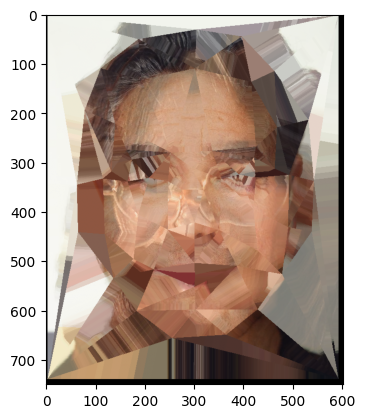

In [16]:
# Compute the avg shape
avg_img = np.zeros(hailey.shape)
avg_shape = ((0.5) * im1_points) + (0.5 * im2_points)

# Transform the triangles from img -> avg shape
for i in range(len(triangles)):
    # Get the indices of the vertices
    a, b, c = triangles[i]
    # print("indices of triangles:", a, b, c)

    # Get the x,y coords of the triangle's vertices
    im1_tri_pts = [np.array([im1_points[a][0], im1_points[b][0], im1_points[c][0]]), np.array([im1_points[a][1], im1_points[b][1], im1_points[c][1]])]
    im2_tri_pts = [np.array([im2_points[a][0], im2_points[b][0], im2_points[c][0]]), np.array([im2_points[a][1], im2_points[b][1], im2_points[c][1]])]
    avg_tri_pts = [np.array([avg_shape[a][0], avg_shape[b][0], avg_shape[c][0]]), np.array([avg_shape[a][1], avg_shape[b][1], avg_shape[c][1]])]
    # print("triangle coords:", im1_tri_pts, im2_tri_pts, avg_tri_pts)

    # Compute Affine transformations, get inverse transformation matrix
    im1_avg_aff = computeAffine(im1_tri_pts, avg_tri_pts)
    im2_avg_aff = computeAffine(im2_tri_pts, avg_tri_pts)

    # print("im1")
    # print(im1_avg_aff.shape)
    # print(im1_avg_aff)

    # print("im2")
    # print(im2_avg_aff.shape)
    # print(im2_avg_aff)

    # im1 triangle polygon
    im1_tri_poly_x, im1_tri_poly_y = sk.draw.polygon([im1_tri_pts[0][0], im1_tri_pts[0][1], im1_tri_pts[0][2]], [im1_tri_pts[1][0], im1_tri_pts[1][1], im1_tri_pts[1][2]])

    # print(im1_tri_poly_x.shape)
    # print(im1_tri_poly_x)

    # im2 triangle polygon
    im2_tri_poly_x, im2_tri_poly_y = sk.draw.polygon([im2_tri_pts[0][0], im2_tri_pts[0][1], im2_tri_pts[0][2]], [im2_tri_pts[1][0], im2_tri_pts[1][1], im2_tri_pts[1][2]])

    # Create the polygon
    avg_poly_x, avg_poly_y = sk.draw.polygon([avg_tri_pts[0][0], avg_tri_pts[0][1], avg_tri_pts[0][2]], [avg_tri_pts[1][0], avg_tri_pts[1][1], avg_tri_pts[1][2]])
    avg_polygon_matrix = np.vstack([avg_poly_y, avg_poly_x, np.ones(len(avg_poly_x))])

    # print(avg_polygon_matrix)

    # print(im1_avg_aff.shape)
    # print(np.linalg.inv(im1_avg_aff).shape)
    # print(avg_polygon_matrix.shape)

    # Multiply the polygon with the inverse affine transform matrix, (x,y) = T-1(x’,y’)
    im1_inv_warp = np.matmul(im1_avg_aff, avg_polygon_matrix).T
    im2_inv_warp = np.matmul(im2_avg_aff, avg_polygon_matrix).T

    # print(im1_inv_warp.shape)
    # print(im1_inv_warp)

    # Remove the 1s from the matrix to get x,y coords
    im1_inv_warp_coords = np.delete(im1_inv_warp, 2, 1)
    im2_inv_warp_coords = np.delete(im2_inv_warp, 2, 1)

    # print("im1 inv warp coords:", im1_inv_warp_coords.shape)
    # print(im1_inv_warp_coords)

    # print("points:", im1_tri_poly_y.shape, im1_tri_poly_x.shape)
    # print("values:", im1_r.shape)

    # Separate color channels
    im1_rgb_coords = np.array((im1_tri_poly_y, im1_tri_poly_x)).T
    im2_rgb_coords = np.array((im2_tri_poly_y, im2_tri_poly_x)).T

    im1_rgb = hailey[im1_tri_poly_y, im1_tri_poly_x,:]
    im2_rgb = george[im2_tri_poly_y, im2_tri_poly_x,:]

    # print(im1_rgb_coords.shape)
    # print(im1_rgb.shape)
    # print(im1_inv_warp_coords.shape)

    # Interpolate the img with the inverse warps: inv warp -> original
    im1_interp = scipy.interpolate.griddata(im1_rgb_coords, im1_rgb, im1_inv_warp_coords, method="nearest")
    im2_interp = scipy.interpolate.griddata(im2_rgb_coords, im2_rgb, im2_inv_warp_coords, method="nearest")

    # print(im1_interp.shape)
    # print(im2_interp.shape)

    # Set image values with the new interpolated values
    avg_img[avg_poly_y, avg_poly_x] = ((0.5) * im1_interp) + (0.5 * im2_interp)

# plt.triplot(triangulation)
# plt.gca().invert_yaxis()
plt.imshow(avg_img)

<h1>Part 3</h1>

In [17]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    res = np.zeros(im1.shape)
    # ...
    return res